# Titanic Challenge 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import seaborn as sns

from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")


In [2]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


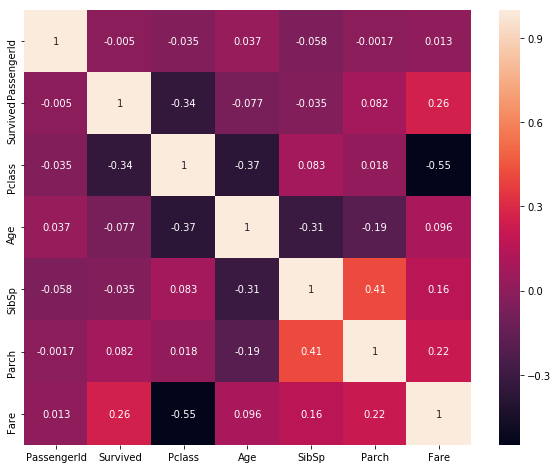

In [4]:
fig= plt.subplots(figsize=(10,8))
sns.heatmap(train.corr(), annot=True)

In [5]:
# Replace male with 1 and female with 0

def fix_data(df, scaling=None):
    
    df = df.set_index("PassengerId")
    df = df.drop(columns=['Name', 'SibSp', 'Parch','Ticket', 'Cabin', 'Embarked'])
    df["Sex"] = df["Sex"].replace(['male'],1).replace(['female'],0)

    means = df.groupby(["Sex","Pclass"]).mean()
    medias = list(means["Age"])

    #matplotlib.use('Qt5Agg')

    #Isto ainda pode ficar numa linha
    df["Age"] = np.where(((df["Sex"]==0) & (df["Pclass"]==1) & (df["Age"].isnull())), medias[0],df["Age"])
    df["Age"] = np.where(((df["Sex"]==0) & (df["Pclass"]==2) & (df["Age"].isnull())), medias[1],df["Age"])
    df["Age"] = np.where(((df["Sex"]==0) & (df["Pclass"]==3) & (df["Age"].isnull())), medias[2],df["Age"])
    df["Age"] = np.where(((df["Sex"]==1) & (df["Pclass"]==1) & (df["Age"].isnull())), medias[3],df["Age"])
    df["Age"] = np.where(((df["Sex"]==1) & (df["Pclass"]==2) & (df["Age"].isnull())), medias[4],df["Age"])
    df["Age"] = np.where(((df["Sex"]==1) & (df["Pclass"]==3) & (df["Age"].isnull())), medias[5],df["Age"])
    
    df = df.assign(Pclass=df['Pclass'].astype('category'))
    df['Pclass'].cat.categories
    df=(pd.get_dummies(df, columns=['Pclass'], drop_first=False))
    
#     fig= plt.subplots(figsize=(10,8))
#     sns.heatmap(df.corr(), annot=True)
    df['Fare'] = df['Fare'].fillna(value=df.Fare.mean())
    
    if(scaling==1):
        sclr = MinMaxScaler()
        sclr.fit(df)
        df = pd.DataFrame(sclr.transform(df), columns=df.columns)

    return df


In [6]:
clfs = {'LR': LogisticRegression(),
        'KNN k=9': KNeighborsClassifier(n_neighbors=9),
        'KNN k=1': KNeighborsClassifier(n_neighbors=1),
        'RandomForest': RandomForestClassifier(max_depth=12, n_estimators=20, n_jobs=-1) }

In [7]:
import matplotlib.pyplot as plt

def plot_roc_curve(roc_auc, fpr, tpr):
    # Function to plot ROC Curve
    # Inputs: 
    #     roc_auc - AU ROC value (float)
    #     fpr - false positive rate (output of roc_curve()) array
    #     tpr - true positive rate (output of roc_curve()) array
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

In [8]:
def test_and_train(X, y, test): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    #logit_clf = LogisticRegression(random_state=0, multi_class='ovr')
    #random_forest = RandomForestClassifier(max_depth=20,random_state=0)
    for key, clf in clfs.items():
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_pred_test[:,1])
        print('The AU ROC of %s is = %f' % (key, roc_auc))
        fpr, tpr,_= roc_curve(y_test,y_pred_test[:,1])
        plot_roc_curve(roc_auc, fpr, tpr)

    clf = RandomForestClassifier()
    rf_rs_parameters_dict = {'max_depth': [20], 'max_features':range(1, 6), 'class_weight':['balanced', None], 'n_jobs':[-1], 'n_estimators':range(10,20)}
    randomized_search = GridSearchCV(clf, rf_rs_parameters_dict, cv=5, scoring="roc_auc", return_train_score=True)
    randomized_search.fit(X_train, y_train)
    y_test = randomized_search.best_estimator_.predict_proba(test)
    #clf.fit(X_train, y_train)
    #y_test = clf.predict_proba(test)
    y_test = [0 if k <= 0.5 else 1 for k in y_test[:,1]]
    y_test = pd.Series(y_test)
    
    return y_test


In [12]:
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train_clean.head()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,1.0,0.271174,0.014151,0.0,0.0,1.0
1,0.0,0.472229,0.139136,1.0,0.0,0.0
2,0.0,0.321438,0.015469,0.0,0.0,1.0
3,0.0,0.434531,0.103644,1.0,0.0,0.0
4,1.0,0.434531,0.015713,0.0,0.0,1.0


The AU ROC of KNN k=9 is = 0.869068


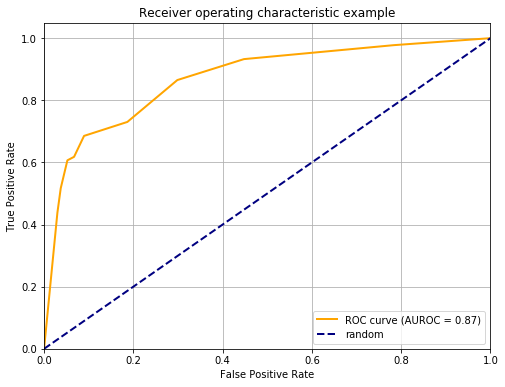

The AU ROC of LR is = 0.868690


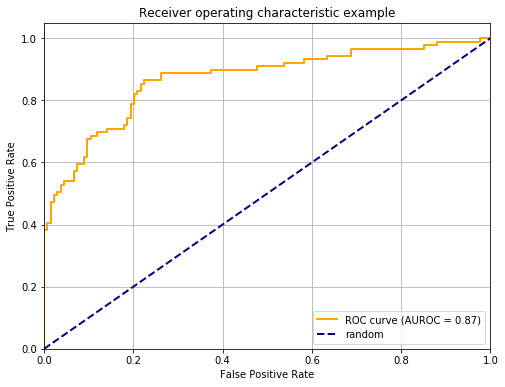

The AU ROC of RandomForest is = 0.867097


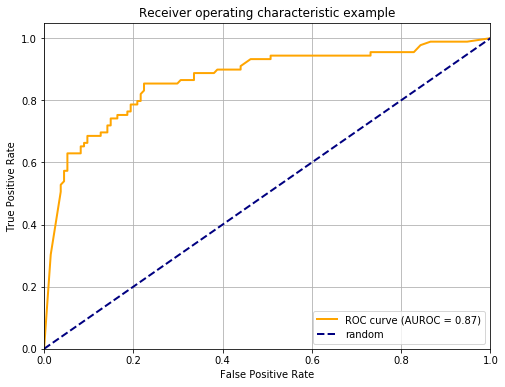

The AU ROC of KNN k=1 is = 0.755115


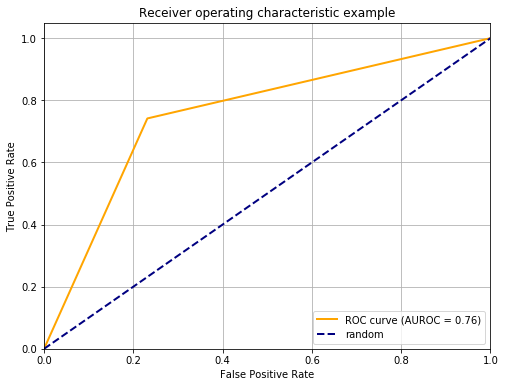

In [9]:
try:
    target = train.pop("Survived")
except:
    _
train_clean = fix_data(train,1)
test_clean = fix_data(test,1)
y_test = test_and_train(train_clean,target, test_clean)

In [10]:
df = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": y_test})
df.head()
df.to_csv('tavisto.csv',index=False)